## Essentials

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def extract_genes_from_pairs(gene_pairs:list)->list:
    '''
    takes a list of gene pairs and returns a list of all genes in the gene pairs

    param:
    ------
        - gene_pairs: list of tuples

    return:
    ------
        - genes: list
    '''
    genes=[]
    for pair in gene_pairs:
        gene1=pair[0]
        gene2=pair[1]
        genes.append(gene1)
        genes.append(gene2)

    genes= list(set(genes))
    return genes


def generate_phenotype_df(pheno_path:str, presence_df:pd.DataFrame=None)->pd.DataFrame:
    '''
    takes in a path to a phenotype file to make a df out of it
    if a presence_df is provided, it will filter the pheno_df to only include samples that are in the presence_df

    param:
    ----
        - pheno_path: str
        - presence_df: pd.DataFrame (optional)

    return:
    ----
        - pheno_df: pd.DataFrame
    '''
    pheno_df = pd.read_csv(pheno_path, index_col=0)

    #samples stripped
    if presence_df is not None:
        samples_presence= presence_df.columns
        mask = pheno_df.index.astype(str).isin(samples_presence)
        pheno_df = pheno_df.loc[mask]

    return pheno_df

# --
# (f'../../data/temp/X_{species}_SxG_filtered_hypo_unknowns_freq5.csv', index_col=0)

presence_path="../../data/temp/X_Escherichia_coli_SxG_filtered_hypo_unknowns_freq5.csv" #add the method that generates presence to this script
presence_df= pd.read_csv(presence_path, index_col=0)
presence_df = presence_df.T #exceptionally because its a SxG
# presence_df.index = presence_df.index.astype(str)

pheno_path="../../metadata/Escherichia_coli/Escherichia_coli_trimethoprim.csv"
pheno_df= generate_phenotype_df(pheno_path, presence_df)
# pheno_df= pd.read_csv(pheno_path, index_col=0)

# --

def split_matrix_by_phenotype(unlabeled_presence_df:pd.DataFrame, pheno_df: pd.DataFrame)->(pd.DataFrame, pd.DataFrame):
    '''
    takes a gene absence presence dataframe (n x m) with the samples classification and splits it to 2 dataframes:
        - one that represents all R samples (samples found in R_list)
        - one that represents all S samples (found in S_list)
    and returns them in this order: R then S

    param:
    ------
        - unlabeled_presence_df: (pd.DataFrame) the data frame output of data_utils.get_gene_presence_matrix
        - R_list: (list) samples genome_id that have a R (1) phenotype
        - S_list: (list) samples having the 0 phenotype
    
    return:
    ------
        - R_df: (pd.DataFrame) data frame where columns are only for R samples
        - S_df: (pd.DataFrame) df where cols are only for S samples

    '''


    # make sure pheno_df doesnthave more samples than those specified in the presence_df, subsample it otherwise
    samples_presence= unlabeled_presence_df.columns
    mask = pheno_df.index.astype(str).isin(samples_presence)
    pheno_df = pheno_df.loc[mask]

    # get the list of R and S samples:
    R=[];S=[];U=[]
    for sample in pheno_df.index:

        if pheno_df.loc[sample].values[0]==1:
            sample=str(sample)
            R.append(str(sample))
        elif pheno_df.loc[sample].values[0]==0:
            sample=str(sample)
            S.append(str(sample))
        else:
            sample=str(sample)
            U.append(str(sample))

    # All we care for care R and S which designate the list of resistant and susceptible samples respectively

    R_df = unlabeled_presence_df[R]
    S_df = unlabeled_presence_df[S]

    #make a subdf of all columns that are in S of the presence_df
    

    return R_df, S_df

def split_samples_list_by_phenotype(pheno_df:pd.DataFrame)->(list,list):
    '''
    takes a dataframe of the phenotypes and splits the samples into 2 lists of samples

    param:
    ------
        - pheno_df: pd.DataFrame
    return:
    ------
        - R_list: list
        - S_list: list
    '''
    # get the list of R and S samples:
    R=[];S=[];U=[]
    for sample in pheno_df.index:

        if pheno_df.loc[sample].values[0]==1:
            sample=str(sample)
            R.append(str(sample))
        elif pheno_df.loc[sample].values[0]==0:
            sample=str(sample)
            S.append(str(sample))
        else:
            sample=str(sample)
            U.append(str(sample))

    return R,S

# R,S=split_samples_list_by_phenotype(pheno_df)

def generate_RS_presence_counts(R:pd.DataFrame, S:pd.DataFrame)->pd.DataFrame:
    '''
    Takes the presence matrix of R samples and S samples and returns a dataframe of the count of genes present and absent in each group of samples.

    *This will memoize the entries needed for the log odds ratio computation.*

    
    e.g., output (w\o the log odds):

    | Gene       | R_present | R_absent | S_present | S_absent |
    |------------|-----------|----------|-----------|----------|
    | group_1001 | 96        | 0        | 187       | 0        |
    | tig        | 96        | 0        | 187       | 0        |
    | legF_1     | 96        | 0        | 187       | 0        |

    param:
    ----------------
        - R: (pd.DataFrame) presence matrix of R samples (output of get_subdf_cols)
        - S: (pd.DataFrame) presence matrix of S samples

    return:
    ----------------
        - new_df: (pd.DataFrame) dataframe of the count of genes present and absent in each group of samples.

    NOTE: it will perform the 0.5 correction - If for one gene any of the counts is 0, it will add 0.5 to all counts for that gene.

    '''
    R_present=R.sum(axis=1)
    R_absent=R.shape[1] - R_present
    S_present=S.sum(axis=1)
    S_absent=S.shape[1]-S_present


    new_df=pd.DataFrame({'R_present':R_present, 'R_absent':R_absent, 'S_present':S_present, 'S_absent':S_absent})

    #the 0.5 correction:
    for index in new_df.index:
        row=list(new_df.loc[index])
        if 0 in row: #check if any of the cols have value 0
            new_df.loc[index]=new_df.loc[index]+0.5

    return new_df

# RS_counts_df=generate_RS_presence_counts(R_df, S_df)

def compute_gene_log_odds_ratio(RS_counts_df:pd.DataFrame)->pd.DataFrame:
    '''
    takes the RS_counts_df and computes the log odds ratio for each gene in the dataframe

    param:
    ------
        - RS_counts_df: pd.DataFrame


    return:
    ------
        - log_odds_df: pd.DataFrame
    '''
    #get the total number of samples in each group
    n_R=len(R); n_S=len(S)


    R_present=RS_counts_df['R_present']
    R_absent=RS_counts_df['R_absent']
    S_present=RS_counts_df['S_present']
    S_absent=RS_counts_df['S_absent']

    log_odds=np.log((R_present/R_absent)/(S_present/S_absent))

    # print(log_odds)

    df=pd.DataFrame({"log_odds":log_odds})
    return df

def get_cooccurence_matrix(presence:pd.DataFrame)->pd.DataFrame:
    '''
    takes a binary GxS presence matrix and returns a GxG co-occurence matrix C 
    Cij= number of samples where gene i and gene j are both present
    (can be performed by matrix multiplication - trace on paper to understand why this works)

    input:
        - df: (pd.DataFrame) binary matrix of genes and samples
    output:
        - G: (nx.Graph) network of gene-gene presence
    '''
    gene_copresence= presence.dot(presence.T)
    return gene_copresence

def generate_RS_copresence_count(R_cooccurence:pd.DataFrame, S_cooccurence:pd.DataFrame, numR:int, numS:int, gene_pairs:list)->pd.DataFrame:
    '''
    Takes the co-occurence matrix of R samples and S samples and returns a dataframe of the count of genes copresent in each group of samples.
    The rows represent all gene-gene pairs and 4 columns are present: R_present, R_absent, S_present, S_absent

    gene_pairs is a list of tuples!

    *This will memoize the entries needed for the log odds ratio computation for gene-gene interaction*

    
    e.g., output (w\o the log odds):

    | Gene       | R_present | R_absent | S_present | S_absent |
    |------------|-----------|----------|-----------|----------|
    | G1-G2      | 96        | 0        | 187       | 0        |
    | G1-G3      | 96        | 0        | 187       | 0        |
    | G2-G3      | 96        | 0        | 187       | 0        |

    This example is without the 0.5 correction:  
        To ensure that the log odds ratio is defined, we will add 0.5 to all counts for each gene-gene pair if any of the counts is 0.

    param:
    ----------------
        - R_cooccurence: (pd.DataFrame) co-occurence matrix of R samples (output of get_cooccurence_matrix)
        - S_cooccurence: (pd.DataFrame) co-occurence matrix of S samples
        - numR: (int) number of R samples
        - numS: (int) number of S samples
        - gene_pairs: (list) list of gene-gene pairs that have a |correlation| of 0.6 or more (list of edges)

    return:
    ----------------
        - new_df: (pd.DataFrame) dataframe of the count of genes present in each group of samples.

    NOTE: it will perform the 0.5 correction - If for one gene any of the counts is 0, it will add 0.5 to all counts for that gene.
    '''


    df=pd.DataFrame(columns=['R_present', 'R_absent', 'S_present', 'S_absent'])

    for gene_pair in gene_pairs:
        gene1=gene_pair[0]
        gene2=gene_pair[1]
        # print(gene1, gene2)

        R_present=R_cooccurence.loc[gene1, gene2]
        R_absent=numR - R_present
        S_present=S_cooccurence.loc[gene1, gene2]
        S_absent=numS - S_present

        #the 0.5 correction:
        if R_present==0 or R_absent==0 or S_present==0 or S_absent==0:
            R_present+=0.5; R_absent+=0.5; S_present+=0.5; S_absent+=0.5

        df.loc[gene1+", "+gene2]=[R_present, R_absent, S_present, S_absent]

        # print(gene_pair, df.loc[gene1+"-"+gene2])

    # print(df)

    return df


def compute_association_log_odds(RS_cooccurence: pd.DataFrame)->pd.DataFrame:
    '''
    takes a RS_cooccurence G^2 x 4 matrix and computes the log odds of all gene pairs
    The idea is to compute the cooccurence log odds of resistance: 
        log ( a * d / c * b )  
        such that
        
         - a: is the number of strains that have both genes and are resistant
         - b: is the number of strains that do not have both genes and are resistant
         - c: is the of strains that have both genes and are susceptible
         - d: is the number of strains that do not have both genes and are susceptible

    param: 
    -------
    - RS_cooccurence: pd.Dataframe, G^2 x 4 matrix that contains the counts of copresence and coabsences of all gene pairs
    
    return:
    --------
    - log_odds_df: pd.DataFrame, the log odds calc of each pair of gene

    _all logs are computable given that RS_cooccurence have gone through the 0.5 correction_

    '''
    R_copresent=RS_cooccurence['R_present']
    R_coabsent=RS_cooccurence['R_absent']
    S_copresent=RS_cooccurence['S_present']
    S_coabsent=RS_cooccurence['S_absent']
    indices=RS_cooccurence.index
    print(indices)

    log_odds=np.log((R_copresent/R_coabsent)/(S_copresent/S_coabsent))

    print(log_odds)

    df=pd.DataFrame({"log_odds":log_odds}, index=indices)

    return df



def compute_cooccurence_LOR(gene_pairs:list, pheno_df:pd.DataFrame=pheno_df, presence_df:pd.DataFrame=presence_df )->pd.DataFrame:
    '''
    takes a phenotype dataframe and a presence dataframe and computes the log odds ratio for each gene pair in the gene_pairs list

    param:
    ------
        - gene_pairs: list
        - pheno_df: pd.DataFrame
        - presence_df: pd.DataFrame

    return:
    ------
        - log_odds_df: pd.DataFrame
    '''
    # -- this step is important ro reduce run time and memory usage: filtering out genes from presence_df that we wont need to compute LOR
    genes=extract_genes_from_pairs(gene_pairs)
    presence_df=presence_df.loc[genes]

    R,S=split_samples_list_by_phenotype(pheno_df)
    R_df,S_df=split_matrix_by_phenotype(presence_df, pheno_df)
    R_cooccurence = get_cooccurence_matrix(R_df)
    S_cooccurence = get_cooccurence_matrix(S_df)
    numR=len(R); numS=len(S)

    RS_copresence_df=generate_RS_copresence_count(R_cooccurence, S_cooccurence, numR, numS, gene_pairs)
    log_odds_gene_pairs=compute_association_log_odds(RS_copresence_df)

    return log_odds_gene_pairs



<>:148: SyntaxWarning: invalid escape sequence '\o'
<>:236: SyntaxWarning: invalid escape sequence '\o'
<>:148: SyntaxWarning: invalid escape sequence '\o'
<>:236: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_504/1951924337.py:148: SyntaxWarning: invalid escape sequence '\o'
  '''
/tmp/ipykernel_504/1951924337.py:236: SyntaxWarning: invalid escape sequence '\o'
  '''


In [16]:
presence_df
# keep only genes in genes as indices and drop the rest


In [12]:
gene_pairs=[]; species="Escherichia_coli"; drug="trimethoprim"
with open(f'../../data/temp/SVM_{species}_{drug}_top_1000_gene_pairs.txt', 'r') as f:
    for line in f:
        gene_pairs.append(tuple(line.strip().split("-")))

genes=extract_genes_from_pairs(gene_pairs=gene_pairs)

In [7]:
R,S=split_samples_list_by_phenotype(pheno_df)
numR=len(R); numS=len(S)
genes_to_keep = pd.read_csv('../../data/temp/SVM_Escherichia_coli_trimethoprim_top_1000_nodes.csv')


In [8]:
genes_to_keep

,Unnamed: 0,0
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
...,...,...
195,195,195
196,196,196
197,197,197
198,198,198


In [4]:
R_df,S_df=split_matrix_by_phenotype(presence_df, pheno_df)
R_cooccurence = get_cooccurence_matrix(R_df)
# S_cooccurence = get_cooccurence_matrix(S_df)
R_cooccurence.to_csv('../../data/temp/R_cooccurence_test.csv')


KeyboardInterrupt: 

In [ ]:
species = "Escherichia_coli"; drug="trimethoprim"
  
gene_pairs=[]
with open(f'../../data/temp/SVM_{species}_{drug}_top_1000_gene_pairs.txt', 'r') as f:
    for line in f:
        gene_pairs.append(tuple(line.strip().split("-")))

In [19]:
LOR = compute_cooccurence_LOR(gene_pairs)

Index(['Cluster 12873, Cluster 20978', 'Cluster 12873, Cluster 49101',
       'Cluster 12873, Cluster 18793', 'Cluster 12873, Cluster 20744',
       'Cluster 12873, Cluster 30747', 'Cluster 12873, Cluster 16272',
       'Cluster 12873, Cluster 41195', 'Cluster 12873, Cluster 20831',
       'Cluster 12873, Cluster 53894', 'Cluster 12873, Cluster 20553',
       ...
       'Cluster 17048, Cluster 84771', 'Cluster 17048, Cluster 28867',
       'Cluster 17048, Cluster 24261', 'Cluster 17048, Cluster 10454',
       'Cluster 84771, Cluster 28867', 'Cluster 84771, Cluster 24261',
       'Cluster 84771, Cluster 10454', 'Cluster 28867, Cluster 24261',
       'Cluster 28867, Cluster 10454', 'Cluster 24261, Cluster 10454'],
      dtype='object', length=499500)
Cluster 12873, Cluster 20978    0.0
Cluster 12873, Cluster 49101    0.0
Cluster 12873, Cluster 18793    0.0
Cluster 12873, Cluster 20744    0.0
Cluster 12873, Cluster 30747    0.0
                               ... 
Cluster 84771, Cluster 24

In [20]:
LOR

,log_odds
"Cluster 12873, Cluster 20978",0.0
"Cluster 12873, Cluster 49101",0.0
"Cluster 12873, Cluster 18793",0.0
"Cluster 12873, Cluster 20744",0.0
"Cluster 12873, Cluster 30747",0.0
...,...
"Cluster 84771, Cluster 24261",0.0
"Cluster 84771, Cluster 10454",0.0
"Cluster 28867, Cluster 24261",0.0
"Cluster 28867, Cluster 10454",0.0


## pairs of nodes

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import networkx as nx


from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
from sklearn.metrics import roc_auc_score

import statsmodels.api as sm
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.formula.api import ols

import sys
sys.path.append("..")
sys.path.append("../..")
from cluster_analysis import *
# from LOR_calculation import *

import warnings

In [ ]:
species='Escherichia_coli'

X_df = pd.read_csv(f'../../data/temp/X_{species}_SxG_filtered_hypo_unknowns_freq5.csv', index_col=0) # filtering

drug='trimethoprim'

pheno_df= pd.read_csv(f'../../metadata/{species}/{species}_{drug}.csv', index_col=0)
y_df=pheno_df
y_df.index = y_df.index.astype('float')

y_df = y_df.sort_index()

y_indices=list(y_df.index)


X_df = X_df.sort_index()
y_df = y_df.sort_index()

y_indices=list(y_df.index)
X_indices=list(X_df.index)

intersection = [i for i in y_indices if i in X_indices]
y_df = y_df.loc[intersection]
X_df = X_df.loc[intersection]

X_df = X_df.sort_index()
y_df = y_df.sort_index() # -- just making sure bcs im paranoid

X = X_df.values
y = y_df.values



labeled_matrix = pd.concat([X_df, y_df], axis=1)
labeled_matrix.shape

In [ ]:
# -- getting top nodes out of SVM weights
n_models = 200


models=[]
for i in range(n_models):
    X_boot, y_boot = resample(X, y, random_state=i)
    model=SGDClassifier(loss='hinge', penalty= 'l1', max_iter=1000, tol=1e-3)
    model.fit(X_boot, y_boot.ravel())
    models.append(model)

weights=np.zeros((n_models, X.shape[1]))
for i in range(n_models):
    weights[i]=models[i].coef_
weights_df = pd.DataFrame(weights, columns=X_df.columns)

In [ ]:
weights_df

In [ ]:
# remove the sum col
weights_df.drop('sum', axis=1, inplace=True)

In [ ]:
# sum the weights for eacg col

sum_weights = weights_df.sum(axis=0)
sum_weights

In [ ]:
#  getting the top genes with the highest weights

top_100_nodes = sum_weights.sort_values(ascending=False).index[:100]
top_1000_nodes = sum_weights.sort_values(ascending=False).index[:1000]

In [ ]:
# save them in temp files:

top_1000_nodes_path = f'../../data/temp/SVM_{species}_{drug}_top_1000_nodes.csv'
top_100_nodes_path = f'../../data/temp/SVM_{species}_{drug}_top_100_nodes.csv'

pd.Series(top_1000_nodes).to_csv(top_1000_nodes_path)
pd.Series(top_100_nodes).to_csv(top_100_nodes_path)

In [ ]:
# -- getting the gene pairs out of top_1000_nodes

gene_pairs = []
for i in range(len(top_1000_nodes)):
    for j in range(i+1, len(top_1000_nodes)):
        gene_pairs.append((top_1000_nodes[i], top_1000_nodes[j]))

#  saving them in temp txt file
with open(f'../../data/temp/SVM_{species}_{drug}_top_1000_gene_pairs.txt', 'w') as f:
    for item in gene_pairs:
        f.write(f"{item[0]}-{item[1]}\n")

## the good stuff

In [5]:
import os
import sys

os.chdir(os.path.expanduser('~/capstone-project'))
sys.path.append('src')

import network_construction

In [7]:
pairs=[('Cluster 11583', 'Cluster 53061'),
 ('Cluster 11583', 'Cluster 38755'),
 ('Cluster 11583', 'Cluster 44531'),
 ('Cluster 11583', 'Cluster 12875'),
 ('Cluster 11583', 'Cluster 5332')]

In [12]:
gene_pairs = network_construction.get_gene_pairs()
pairs = gene_pairs[:100000]

lor_1 = network_construction.compute_cooccurence_LOR(pairs)

Index(['Cluster 11583, Cluster 53061', 'Cluster 11583, Cluster 38755',
       'Cluster 11583, Cluster 44531', 'Cluster 11583, Cluster 12875',
       'Cluster 11583, Cluster 5332', 'Cluster 11583, Cluster 86144',
       'Cluster 11583, Cluster 586', 'Cluster 11583, Cluster 74730',
       'Cluster 11583, Cluster 11551', 'Cluster 11583, Cluster 23769',
       ...
       'Cluster 43202, Cluster 25724', 'Cluster 43202, Cluster 85917',
       'Cluster 43202, Cluster 10636', 'Cluster 43202, Cluster 10372',
       'Cluster 43202, Cluster 23537', 'Cluster 43202, Cluster 68086',
       'Cluster 43202, Cluster 41195', 'Cluster 43202, Cluster 42314',
       'Cluster 43202, Cluster 61134', 'Cluster 43202, Cluster 41850'],
      dtype='object', length=100000)
Cluster 11583, Cluster 53061   -0.858880
Cluster 11583, Cluster 38755    0.269622
Cluster 11583, Cluster 44531    0.269622
Cluster 11583, Cluster 12875    1.202787
Cluster 11583, Cluster 5332     3.010539
                                  ...  

/home/rayane/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [2]:
LOR = network_construction.compute_cooccurence_LOR()

/home/rayane/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
LOR.to_csv('data/temp/LOR_Escherichia_coli_trimethoprim.csv')

In [9]:
LOR.loc['Cluster 11583, Cluster 53061'].log_odds

-0.858879824660816

In [6]:
LOR=pd.read_csv('data/temp/LOR_Escherichia_coli_trimethoprim.csv', index_col=0)

In [3]:
import networkx as nx

threshold=0.5; G= nx.Graph()
for pair in LOR.index.to_list():
    log_odds_value = LOR.loc[pair].log_odds
    # print(pair, LOR.loc[pair])
    if log_odds_value > threshold or log_odds_value < -threshold:
        G.add_edge(pair.split(',')[0], pair.split(',')[1].strip(), weight=log_odds_value)
        # print('added')


NameError: name 'LOR' is not defined

In [27]:
G.number_of_edges()
nx.write_graphml(G, 'data/temp/3_network_Escherichia_coli_trimethoprim.graphml')

In [8]:
import networkx as nx
G = nx.read_graphml('data/temp/1_network_Escherichia_coli_trimethoprim.graphml')

In [9]:
G.number_of_edges()

261838

In [12]:
import sys
sys.path.append("..")

import network_analysis

network_analysis.plot_degree_distribution(G, '3 thresh', weighted=False)

In [31]:
network_analysis.plot_log_log(G, '3 thresh', weighted=True)

R squared: 0.013050480201453052


0.013050480201453052

In [32]:
# max log odds value
max_log_odds = LOR.log_odds.max()

<Axes: >

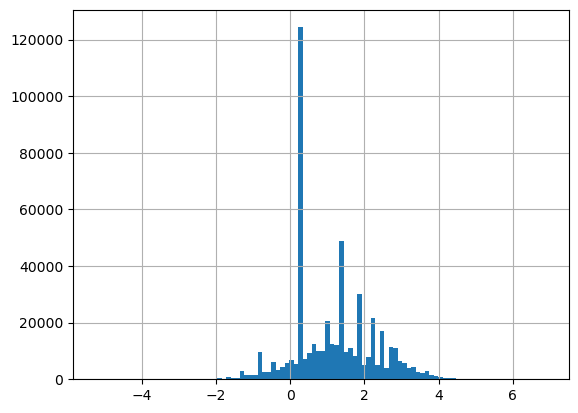

In [34]:
# distribution of log odds values
log_odds_values = LOR.log_odds
log_odds_values.hist(bins=100)


### the paper's formula

In [1]:
import sys
sys.path.append("..")
import network_construction
import network_analysis

# LORRRR = network_construction.compute_cooccurence_LOR()

In [13]:
LORRRR

,log_odds
"Cluster 11583, Cluster 53061",-1.184423
"Cluster 11583, Cluster 38755",-0.269622
"Cluster 11583, Cluster 44531",-0.269622
"Cluster 11583, Cluster 12875",0.629794
"Cluster 11583, Cluster 5332",2.405562
...,...
"Cluster 249, Cluster 17365",0.461648
"Cluster 249, Cluster 1951",0.796541
"Cluster 41741, Cluster 17365",0.298989
"Cluster 41741, Cluster 1951",-0.017168


In [14]:
test_G = nx.Graph()

for pair in LORRRR.index.to_list():
    log_odds_value = LORRRR.loc[pair].log_odds
    if log_odds_value > 0.5 or log_odds_value < -0.5:
        test_G.add_edge(pair.split(',')[0], pair.split(',')[1].strip(), weight=log_odds_value)


In [15]:
nx.write_graphml(test_G, 'data/temp/paperFormula_0.5_network_Escherichia_coli_trimethoprim.graphml')

In [3]:
import networkx as nx
test_G = nx.read_graphml('data/temp/paperFormula_0.5_network_Escherichia_coli_trimethoprim.graphml')    

In [5]:
network_analysis.plot_degree_distribution(test_G,weighted=True)

: 